In [1]:
from models.PINN import *
import matplotlib.pyplot as plt
import torch.utils.data as data
import numpy as np
import time
from mpl_toolkits.mplot3d import Axes3D

In [4]:
dt = 0.01
t_0 = 0.
t_f = 10.

t = torch.linspace(t_0, t_f, int(t_f/dt))
t= t.reshape((len(t), 1))
x_0 = torch.tensor([0., -1., 9.])
x_f =torch.tensor([5., 7., -3])
layers = [1, 50, 50, 3]
loss_arr = []
steps=50000
lr=0.1



epoch: 100.000000, total loss: 0.02855, data loss: 0.01223, pde loss: 0.00326, avg. d_sum: 0.053089
epoch: 200.000000, total loss: 0.02855, data loss: 0.01342, pde loss: 0.00303, avg. d_sum: 0.053699
epoch: 300.000000, total loss: 0.15907, data loss: 0.13304, pde loss: 0.00520, avg. d_sum: 0.067982
epoch: 400.000000, total loss: 0.31556, data loss: 0.30386, pde loss: 0.00234, avg. d_sum: 0.040927
epoch: 500.000000, total loss: 0.14913, data loss: 0.13116, pde loss: 0.00359, avg. d_sum: 0.057932
epoch: 600.000000, total loss: 0.05295, data loss: 0.03539, pde loss: 0.00351, avg. d_sum: 0.056561
epoch: 700.000000, total loss: 47.59901, data loss: 44.23440, pde loss: 0.67292, avg. d_sum: 0.754596
epoch: 800.000000, total loss: 2.90321, data loss: 1.03726, pde loss: 0.37319, avg. d_sum: 0.398313
epoch: 900.000000, total loss: 0.79789, data loss: 0.08016, pde loss: 0.14355, avg. d_sum: 0.211043
epoch: 1000.000000, total loss: 0.34841, data loss: 0.00236, pde loss: 0.06921, avg. d_sum: 0.1181

KeyboardInterrupt: 

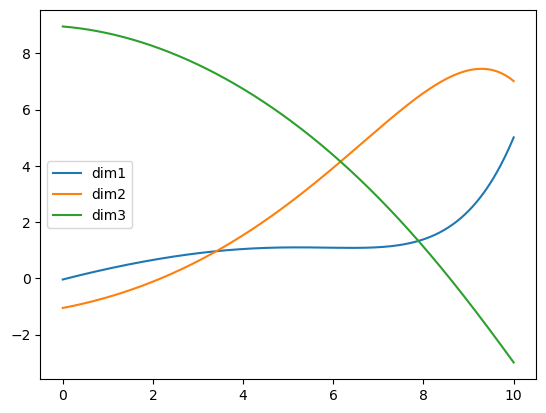

In [5]:
t_0, t_f = torch.tensor([t_0]), torch.tensor([t_f])
forward_model = PINN(layers, t_0, t_f)
params = list(forward_model.dnn.parameters())
optimizer = optim.Adam(params, lr=lr, eps=1e-08, betas = (0.8, 0.99), weight_decay=0, amsgrad=False)

for i in range(steps):
    optimizer.zero_grad()
    loss, loss_data, loss_ode, u_t = forward_model.loss(t_0, t_f, x_0, x_f, t)
    loss.backward()
    optimizer.step()
    forward_model.iter+=1
    if forward_model.iter % 100 == 0:
        rollout = forward_model.dnn(t).clone().detach().numpy()
        u_sum = np.array([u.detach().numpy().sum() for u in u_t]).mean()

        plt.clf()
        plt.plot(t.clone().detach().numpy(), rollout[:, 0], label = 'dim1')
        plt.plot(t.clone().detach().numpy(), rollout[:, 1], label = 'dim2')
        plt.plot(t.clone().detach().numpy(), rollout[:, 2], label = 'dim3')
        plt.legend()
        plt.savefig('dynamics.png')
        print(
            'epoch: %f, total loss: %.5f, data loss: %.5f, pde loss: %.5f, avg. d_sum: %5f' %
            (
                forward_model.iter,
                loss, 
                loss_data, 
                loss_ode,
                u_sum
            )
        )



In [ ]:
du_dt = u_t
rhs = torch.zeros_like(du_dt[:, 0])
constraint = du_dt[:, 0] + du_dt[:, 1] + du_dt[:, 2]
du_dt

tensor([[[ 0.3973],
         [ 0.6757],
         [-0.9998]],

        [[ 0.3988],
         [ 0.6778],
         [-1.0037]],

        [[ 0.4003],
         [ 0.6799],
         [-1.0075]],

        ...,

        [[-0.0345],
         [ 0.0321],
         [ 0.0332]],

        [[-0.0361],
         [ 0.0298],
         [ 0.0369]],

        [[-0.0377],
         [ 0.0275],
         [ 0.0405]]], grad_fn=<StackBackward0>)

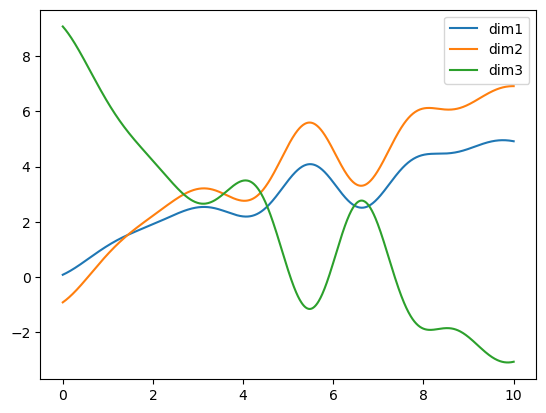

In [ ]:
#u = forward_model.dnn(t).clone().detach().numpy()
#np.save('dumb_data.npy', u)

u = np.load("dumb_data.npy")
plt.clf()
plt.plot(t.clone().detach().numpy(), u[:, 0], label = 'dim1')
plt.plot(t.clone().detach().numpy(), u[:, 1], label = 'dim2')
plt.plot(t.clone().detach().numpy(), u[:, 2], label = 'dim3')
plt.legend()
plt.show()

In [ ]:
u.shape

torch.Size([1000, 3])

In [ ]:

# Instantiate the model
autoencoder = Autodecoder()

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss for reconstruction
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-2)
u = torch.tensor(u)
for epoch in range(1000):
    optimizer.zero_grad()
    _, u_hat = autoencoder(u)
    loss = criterion(u, u_hat)
    loss.backward()
    optimizer.step()
    print(loss.item())



/tmp/ipykernel_246948/1378732564.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = torch.tensor(u)


11.13469123840332
9.352265357971191
9.264266014099121
9.099435806274414
8.828055381774902
8.82274055480957
8.843280792236328
8.842381477355957
8.829453468322754
8.822308540344238
8.819385528564453
8.81861686706543
8.818929672241211
8.819652557373047
8.82044506072998
8.821152687072754
8.82169246673584
8.82200813293457
8.822100639343262
8.821993827819824
8.821728706359863
8.821355819702148
8.82091999053955
8.820469856262207
8.820043563842773
8.819670677185059
8.819375038146973
8.819168090820312
8.819050788879395
8.819015502929688
8.819047927856445
8.819128036499023
8.819229125976562
8.819334983825684
8.81942367553711
8.819482803344727
8.819509506225586
8.819497108459473
8.8194580078125
8.819393157958984
8.819318771362305
8.81924057006836
8.819171905517578
8.81911563873291
8.81907844543457
8.81905746459961
8.819049835205078
8.81905746459961
8.819071769714355
8.81908893585205
8.81910514831543
8.819119453430176
8.819128036499023
8.81912899017334
8.819123268127441
8.819111824035645
8.8190975

KeyboardInterrupt: 

/tmp/ipykernel_246948/3814343081.py:7: RuntimeWarning: invalid value encountered in divide
  normalized_data = (data - min_vals) / (max_vals - min_vals)


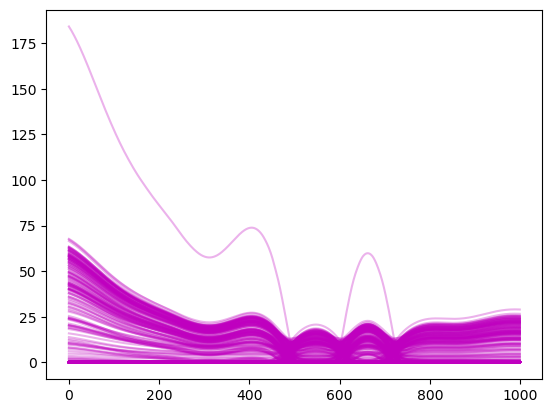

In [ ]:
HD, _ = autoencoder(u)
data = HD.clone().detach().numpy()
min_vals = np.min(data, axis=0)  # Compute min for each neuron
max_vals = np.max(data, axis=0)  # Compute max for each neuron

# Normalize each neuron's data between 0 and 1
normalized_data = (data - min_vals) / (max_vals - min_vals)
plt.clf()
plt.plot(data, color='m', alpha=0.3)
plt.show()

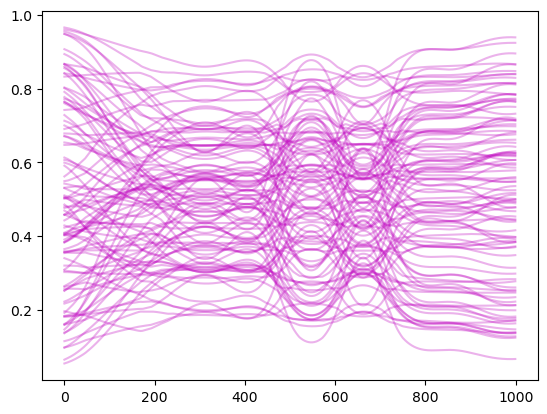

In [ ]:
# Define a simple neural network
class HighDimensionalGenerator(nn.Module):
    def __init__(self):
        super(HighDimensionalGenerator, self).__init__()
        self.fc1 = nn.Linear(3, 50)  # First hidden layer
        self.fc2 = nn.Linear(50, 100)  # Output layer to 100 dimensions
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function
        x = torch.sigmoid(self.fc2(x))
        return x

# Create the model and generate high-dimensional data
model = HighDimensionalGenerator()
generated_data = model(u)

# Convert to numpy for further use
data = generated_data.detach().numpy()
min_vals = np.min(data, axis=0)  # Compute min for each neuron
max_vals = np.max(data, axis=0)  # Compute max for each neuron

# Normalize each neuron's data between 0 and 1
normalized_data = (data - min_vals) / (max_vals - min_vals)

plt.clf()
plt.plot(data, color='m', alpha=0.3)
plt.show()

In [ ]:
HD.shape

(1000, 100)